#WESAD Downloading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
drive.flush_and_unmount()

In [ ]:
!wget -O /content/drive/MyDrive/Thesis/WESAD.zip 'https://uni-siegen.sciebo.de/s/HGdUkoNlW1Ub0Gx/download'

--2025-03-25 14:15:33--  https://uni-siegen.sciebo.de/s/HGdUkoNlW1Ub0Gx/download
Resolving uni-siegen.sciebo.de (uni-siegen.sciebo.de)... 128.176.1.2
Connecting to uni-siegen.sciebo.de (uni-siegen.sciebo.de)|128.176.1.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2249444501 (2.1G) [application/zip]
Saving to: ‘/content/drive/MyDrive/Thesis/WESAD.zip’

/content/drive/MyDr 100%[===================>]   2.09G  16.9MB/s    in 2m 11s  

2025-03-25 14:17:45 (16.4 MB/s) - ‘/content/drive/MyDrive/Thesis/WESAD.zip’ saved [2249444501/2249444501]



In [ ]:
os.makedirs(extract_path, exist_ok=True)

subjects = []
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  names = [name for name in zip_ref.namelist() if '.pkl' in name]

  for name in names:
    zip_ref.extract(name, extract_path)
names

['WESAD/S10/S10.pkl',
 'WESAD/S11/S11.pkl',
 'WESAD/S13/S13.pkl',
 'WESAD/S14/S14.pkl',
 'WESAD/S15/S15.pkl',
 'WESAD/S16/S16.pkl',
 'WESAD/S17/S17.pkl',
 'WESAD/S2/S2.pkl',
 'WESAD/S3/S3.pkl',
 'WESAD/S4/S4.pkl',
 'WESAD/S5/S5.pkl',
 'WESAD/S6/S6.pkl',
 'WESAD/S7/S7.pkl',
 'WESAD/S8/S8.pkl',
 'WESAD/S9/S9.pkl']

#Preprocessing

In [ ]:
!pip install neurokit2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.1/693.1 kB 41.1 MB/s eta 0:00:00


In [ ]:
import neurokit2 as nk
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil, floor
from scipy.signal import butter, filtfilt
import time
from datetime import datetime
import zipfile
import os
import shutil

##Структура датасета

```
Это словарик со следующей структурой:
{
  "subject": "SX", где X - номер пациента,
  "signal" : {
    "chest" : {
      "ACC" : (3847200, 3), #5 496 секунд (700 Гц)
      "ECG" : (3847200, 1), #5 496 секунд (700 Гц)
      "EMG" : (3847200, 1), #5 496 секунд (700 Гц)
      "EDA" : (3847200, 1), #5 496 секунд (700 Гц)
      "Temp" : (3847200, 1), #5 496 секунд (700 Гц)
      "Resp" : (3847200, 1) #5 496 секунд (700 Гц)
    },
    "wrist" : {
      "ACC" : (175872, 3), #5 496 секунд (32 Гц)
      "BVP" : (351744, 1), #5 496 секунд (64 Гц)
      "EDA" : (21984, 1), #5 496 секунд (4 Гц)
      "TEMP" : (21984, 1) #5 496 секунд (4 Гц)
    }
  },
  "labels" : (3847200, 1) #5 496 секунд (700 гц)
}
```

In [ ]:
class Signal:
  """
  name - название сигнала
  sampling - частота дискретизации (в Гц)
  data - сам массив данных
  """
  def __init__(self, name, sampling, data):
    self.__name = name
    self.__sampling = sampling

    if 'EDA' in name:
      self.__data = {"Clean": nk.eda_clean(data, sampling_rate=sampling)}
      components = nk.eda_phasic(self.__data['Clean'], sampling_rate=sampling)
      self.__data['Phasic'], self.__data['Tonic'] = components['EDA_Phasic'].values, components['EDA_Tonic'].values
      self.__data['Peaks'], _ = nk.eda_peaks(self.__data['Clean'], sampling_rate=sampling)
      self.__data['Peaks'] = self.__data['Peaks']["SCR_Peaks"].values
    elif "BVP" in name:
      self.__data, _ = nk.ppg_process(data, sampling_rate=sampling)
    elif "ECG" in name:
      self.__data, _ = nk.ecg_process(data, sampling_rate=sampling)
    else:
      self.__data = data

  def __str__(self):
    return f"Name: {self.__name}, Count: {len(self.__data)}, {self.__sampling} Hz"

  def get_freq(self):
    return self.__sampling

  def get_name(self):
    return self.__name

  def get_data(self):
    return self.__data

  def get_data_segment(self, time_begin, time_end, origin):
    if "EDA" in self.__name:
      return {
          "Clean": self.__data["Clean"][floor((time_begin - origin) * self.__sampling) : floor((time_end - origin) * self.__sampling) + 1],
          "Tonic": self.__data["Tonic"][floor((time_begin - origin) * self.__sampling) : floor((time_end - origin) * self.__sampling) + 1],
          "Phasic": self.__data["Phasic"][floor((time_begin - origin) * self.__sampling) : floor((time_end - origin) * self.__sampling) + 1],
          "Peaks": self.__data["Peaks"][floor((time_begin - origin) * self.__sampling) : floor((time_end - origin) * self.__sampling) + 1]
      }
    elif "BVP" in self.__name:
      return {
          "Clean": (self.__data["PPG_Clean"].values)[floor((time_begin - origin) * self.__sampling) : floor((time_end - origin) * self.__sampling) + 1],
          "Rate": (self.__data["PPG_Rate"].values)[floor((time_begin - origin) * self.__sampling) : floor((time_end - origin) * self.__sampling) + 1],
          "Peaks": (self.__data["PPG_Peaks"].values)[floor((time_begin - origin) * self.__sampling) : floor((time_end - origin) * self.__sampling) + 1],
      }
    elif "ECG" in self.__name:
      return {
          "Clean": (self.__data["ECG_Clean"].values)[floor((time_begin - origin) * self.__sampling) : floor((time_end - origin) * self.__sampling) + 1],
          "Rate": (self.__data["ECG_Rate"].values)[floor((time_begin - origin) * self.__sampling) : floor((time_end - origin) * self.__sampling) + 1],
          "Peaks": (self.__data["ECG_R_Peaks"].values)[floor((time_begin - origin) * self.__sampling) : floor((time_end - origin) * self.__sampling) + 1]
      }
    return self.__data[floor((time_begin - origin) * self.__sampling) : floor((time_end - origin) * self.__sampling) + 1]

"""
Класс одного участника эксперимента
subject_keys = ['singal', 'label', 'subject']
signal_keys = ['chest', 'wrist']
chest_keys = ['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp']
wrist_keys = ['ACC', 'EDA', 'TEMP', 'BVP']
"""
class WesadSubject:
  """
  Считываем данные одного пациента.

  main_path - путь на биомедицинские данные пациентов
  subject_name - номер пациента
  """
  def __init__(self, main_path, subject_name, metric_conf=None):
    with open(os.path.join(main_path, subject_name) + '/' + subject_name + '.pkl', 'rb') as file:
          data = pickle.load(file, encoding='latin1')
    self.__name = subject_name
    self.__data = None

    self.__metrics = {
        "chest" : {
          "ACC" : ["MAX", "MIN", "STD", "MEAN", "RANGE"],
          "ECG" : ["MAX", "MIN", "STD", "MEAN", "RANGE"],
          "EMG" : ["MAX", "MIN", "STD", "MEAN", "RANGE"],
          "EDA" : ["MAX", "MIN", "STD", "MEAN", "RANGE"],
          "Temp" : ["MAX", "MIN", "STD", "MEAN", "RANGE"],
          "Resp" : ["MAX", "MIN", "STD", "MEAN", "RANGE"]
        },
        "wrist" : {
            "ACC" : ["MAX", "MIN", "STD", "MEAN", "RANGE"],
            "EDA" : ["MAX", "MIN", "STD", "MEAN", "RANGE"],
            "TEMP" : ["MAX", "MIN", "STD", "MEAN", "RANGE"],
            "BVP" : ["MAX", "MIN", "STD", "MEAN", "RANGE"]
        }
    } if not metric_conf else metric_conf

    self.__restructure_data(data)

  """
  Возвращает номер пациента в формате SX
  """
  def get_name(self):
    return self.__name

  """
  Устанавливает конфигурацию для метрик
  """
  def set_metrics_conf(self, conf):
    for key in self.__metrics['wrist']:
      self.__metrics['wrist'][key] = conf['wrist'][key]

    for key in self.__metrics['chest']:
      self.__metrics['chest'][key] = conf['chest'][key]

  """
  Возвращает количество метрик
  """
  def get_metric_count(self):
    sm = 0

    for key in self.__metrics['wrist']:
      if key == "ACC":
        sm += len(self.__metrics['wrist'][key]) * 3
      else:
        sm += len(self.__metrics['wrist'][key])

    for key in self.__metrics['chest']:
      if key == "ACC":
        sm += len(self.__metrics['chest'][key]) * 3
      else:
        sm += len(self.__metrics['chest'][key])

    return sm

  """
  Вырезаем кусочек сигнала по данным границам, приводя их к требуемой частоте.
  """
  def __extract_signal_method(self, time_interval, signal_name, signal):
    freq = self.__sampling(signal_name)
    return signal[time_interval[0] * freq : time_interval[1] * freq + 1]

  """
  Реструктуризируем сигнал:
  - Вырезаем только кусочки, которые классифицированы, как baseline и stress
  - Разделяем данные на два класса: baseline (0) и stress (1)
  - Разделяем сигналы между собой. Ex: ACC переводим из (:, 3) в  ACC_i : (:, i). См. структура датасета
  """
  def __restructure_data(self, data):
    baseline_class_mask = np.where((data['label'] == 1))[0]
    baseline_start, baseline_end = baseline_class_mask[0], baseline_class_mask[-1]

    stress_class_mask = np.where((data['label'] == 2))[0]
    stress_start, stress_end = stress_class_mask[0], stress_class_mask[-1]

    amusement_class_mask = np.where((data['label'] == 3))[0]
    amusement_start, amusement_end = amusement_class_mask[0], amusement_class_mask[-1]

    baseline_data = {"time_interval": (ceil(baseline_start / 700), floor(baseline_end / 700)), 'signals': {}}
    stress_data = {"time_interval": (ceil(stress_start / 700), floor(stress_end / 700)), 'signals': {}}
    amusement_data = {"time_interval": (ceil(amusement_start / 700), floor(amusement_end / 700)), 'signals': {}}

    for device in data['signal']:
      print('device: ', device)
      for signal_type in data['signal'][device]:
        print('\ttype: ', signal_type)
        for i in range(data['signal'][device][signal_type].shape[1]):
          signal_name = '_'.join([device, signal_type, str(i)])
          signal = data['signal'][device][signal_type][:, i]

          baseline_data['signals'][signal_name] = self.__extract_signal_method(baseline_data['time_interval'], signal_name, signal)
          stress_data['signals'][signal_name] = self.__extract_signal_method(stress_data['time_interval'], signal_name, signal)
          amusement_data['signals'][signal_name] = self.__extract_signal_method(amusement_data['time_interval'], signal_name, signal)

          if len(baseline_data['signals'][signal_name]) == 0:
            raise ValueError(f"baseline signal {signal_name} has a zero length. The length of the signal is {len(signal)} with time interval {baseline_data['time_interval']}")
          if len(stress_data['signals'][signal_name]) == 0:
            raise ValueError(f"stress signal {signal_name} has a zero length. The length of the signal is {len(signal)} with time interval {stress_data['time_interval']}")
          if len(amusement_data['signals'][signal_name]) == 0:
            raise ValueError(f"amusement signal {signal_name} has a zero length. The length of the signal is {len(signal)} with time interval {amusement_data['time_interval']}")

    self.__data = {'baseline': baseline_data, 'stress': stress_data, 'amusement': amusement_data}

    for signal_name in self.__data['baseline']['signals']:
      self.__data['baseline']['signals'][signal_name] = Signal(signal_name, self.__sampling(signal_name), self.__data['baseline']['signals'][signal_name])
      self.__data['stress']['signals'][signal_name] = Signal(signal_name, self.__sampling(signal_name), self.__data['stress']['signals'][signal_name])
      self.__data['amusement']['signals'][signal_name] = Signal(signal_name, self.__sampling(signal_name), self.__data['amusement']['signals'][signal_name])

      if len(self.__data['baseline']['signals'][signal_name].get_data()) == 0:
        raise ValueError(f"baseline signal {signal_name} has a zero length.")
      if len(self.__data['stress']['signals'][signal_name].get_data()) == 0:
        raise ValueError(f"stress signal {signal_name} has a zero length.")
      if len(self.__data['amusement']['signals'][signal_name].get_data()) == 0:
        raise ValueError(f"amusement signal {signal_name} has a zero length.")

    print(f"\nИтого количество измерений в каждой классе:\n\tНейтральное состояние длится {self.__data['baseline']['time_interval'][1] - self.__data['baseline']['time_interval'][0] + 1} секунд.\n\tСтрессовое состояние длится {self.__data['stress']['time_interval'][1] - self.__data['stress']['time_interval'][0] + 1} секунд.\n\tСостояние веселья длится {self.__data['amusement']['time_interval'][1] - self.__data['amusement']['time_interval'][0] + 1} секунд.")

  """
  По названию и прибору измерений, записанному в signal_name определяет частоту дискретизации сигнала
  """
  def __sampling(self, signal_name):
    if signal_name.startswith("wrist_ACC"):
      return 32
    if signal_name.startswith("wrist_BVP"):
      return 64
    if signal_name.startswith("wrist_EDA"):
      return 4
    if signal_name.startswith("wrist_TEMP"):
      return 4
    return 700

  """
  Формирование датасета размерности (n x 1 x m), где размерность - (количество всего объектов, количество timesteps, количество метрик)
  """
  def preprocess_data_wots(self, window_size, timestep=45, signal_class="baseline"):
      if not self.__data:
          raise ValueError("There is no data.")
      if signal_class not in ['baseline', 'stress', 'amusement']:
          raise ValueError(f"Incorrect signal_class name.\nThe valid options are 'baseline', 'stress' and 'amusement', but '{signal_class}' was received.")

      start = self.__data[signal_class]['time_interval'][0] + window_size
      end = self.__data[signal_class]['time_interval'][1] + 1
      num_windows = ceil((end - start) / timestep)

      num_metrics = self.get_metric_count()
      dataset = np.zeros((num_windows, 1, num_metrics))

      for i, right_border in enumerate(range(start, end, timestep)):
          metrics = []
          for signal_name in self.__data[signal_class]['signals']:
              divice, name, _ = signal_name.split("_")
              if not self.__metrics[divice][name]:
                continue

              signal = self.__data[signal_class]['signals'][signal_name]


              metrics.extend(self.make_metrics(
                  signal.get_data_segment(right_border - window_size, right_border, self.__data[signal_class]['time_interval'][0]),
                  signal.get_name(),
                  signal.get_freq(),
                  type=signal_class
              ))
          dataset[i, 0, :] = metrics

      return dataset

  """
  Формирование датасета размерности (n x t x m), где размерность - (количество всего объектов, количество timesteps, количество метрик)
  """
  def preprocess_data_wts(self, inner_window_size, outer_window_size, inner_window_timestep=30, outer_window_timestep=45, signal_class="baseline"):
      if not self.__data:
          raise ValueError("There is no data.")
      if inner_window_size > outer_window_size:
          raise ValueError("The size of the inner window is more than the size of the outer window.")
      if signal_class not in ['baseline', 'stress', 'amusement']:
          raise ValueError(f"Incorrect signal_class name.\nThe valid options are 'baseline' and 'stress', but '{signal_class}' was received.")


      start = self.__data[signal_class]['time_interval'][0] + outer_window_size
      end = self.__data[signal_class]['time_interval'][1] + 1
      num_outer_windows = floor((end - start) / outer_window_timestep) + 1
      num_inner_windows = floor((outer_window_size - inner_window_size) / inner_window_timestep) + 1

      num_metrics = self.get_metric_count()
      dataset = np.zeros((num_outer_windows, num_inner_windows, num_metrics))

      for i, outer_right_border in enumerate(range(start, end, outer_window_timestep)):
          for j, inner_right_border in enumerate(np.arange(outer_right_border - outer_window_size + inner_window_size, outer_right_border + 1, inner_window_timestep)):
              metrics = []
              for signal_name in self.__data[signal_class]['signals']:
                  divice, name, _ = signal_name.split("_")
                  if not self.__metrics[divice][name]:
                    continue

                  signal = self.__data[signal_class]['signals'][signal_name]
                  window = signal.get_data_segment(inner_right_border - inner_window_size, inner_right_border, self.__data[signal_class]['time_interval'][0])
                  self.last_time_interval = (inner_right_border - inner_window_size, inner_right_border, self.__data[signal_class]['time_interval'])

                  if len(window) == 0:
                    raise ValueError(f"Given {signal_name} window has a zero length. Here's parameters:\n\ttime_interval: {self.__data[signal_class]['time_interval']},\n\tinner_window_bounders: {(inner_right_border - inner_window_size, inner_right_border)}\n\tlength of the signal: {len(signal.get_data())} with {signal.get_freq()} frequence.")

                  metrics.extend(self.make_metrics(
                      window,
                      signal.get_name(),
                      signal.get_freq(),
                      type=signal_class
                  ))

              dataset[i, j, :] = metrics

      return dataset

  def plot_signal(self, device, signal_name, signal_class="baseline"):
        """
        Plot the specified signal from the given device and class.

        Parameters:
        - device: 'chest' or 'wrist'
        - signal_name: name of the signal (e.g., 'ACC', 'EDA', 'BVP')
        - signal_class: 'baseline' or 'stress' (default: 'baseline')
        """
        if signal_class not in ['baseline', 'stress', 'amusement']:
            raise ValueError("signal_class must be either 'baseline', 'stress' or 'amusement'")

        if device not in ['chest', 'wrist']:
            raise ValueError("device must be either 'chest' or 'wrist'")

        # Find the full signal name in the data
        full_signal_name = None
        for key in self.__data[signal_class]['signals']:
            if key.startswith(f"{device}_{signal_name}"):
                full_signal_name = key
                break

        if full_signal_name is None:
            raise ValueError(f"Signal {signal_name} not found for device {device}")

        signal = self.__data[signal_class]['signals'][full_signal_name]
        data = signal.get_data()
        sampling_rate = signal.get_freq()

        # Create time axis in seconds
        time = np.arange(len(data)) / sampling_rate

        plt.figure(figsize=(12, 4))
        plt.plot(time, data)

        title = f"{device.upper()} {signal_name} Signal ({signal_class.capitalize()} state)"
        if "EDA" in signal_name:
            title += "\n(Clean signal)"
        plt.title(title)
        plt.xlabel("Time (seconds)")
        plt.ylabel("Amplitude")

        plt.grid(True)
        plt.tight_layout()
        plt.show()

  """
  Генерация метрик
  """

  def make_metrics(self, window, signal_name, freq, type='baseline'):
      metrics = []
      names = []

      if "wrist_EDA" in signal_name and self.__metrics['wrist']['EDA'] or "chest_EDA" in signal_name and self.__metrics['chest']['EDA']:
          device = signal_name.split("_")[0]

          for key in self.__metrics[device]['EDA']:
            if key == "EDA_MAX":
              metrics.append(np.max(window["Clean"]))
            elif key == "EDA_MIN":
              metrics.append(np.min(window["Clean"]))
            elif key == "EDA_MEAN":
              metrics.append(np.mean(window["Clean"]))
            elif key == "EDA_STD":
              metrics.append(np.std(window["Clean"]))
            elif key == "EDA_RANGE":
              metrics.append(np.max(window["Clean"]) - np.min(window["Clean"]))
            elif key == "SCR_RANGE":
              metrics.append(np.max(window["Phasic"]) - np.min(window["Phasic"]))
            elif key == "SCL_MEAN":
              metrics.append(np.mean(window["Tonic"]))
            elif key == "SCL_STD":
              metrics.append(np.std(window["Tonic"]))
            elif key == "SCL_MAX":
              metrics.append(np.max(window['Tonic']))
            elif key == "SCL_MIN":
              metrics.append(np.min(window['Tonic']))
            elif key == "SCR_PEAKS_NUMBER":
              metrics.append(np.sum(window['Peaks']))
            elif key == "SCR_MEAN":
              metrics.append(np.mean(window['Phasic']))
            elif key == "SCR_STD":
              metrics.append(np.std(window['Phasic']))
            elif key == "SCR_MIN":
              metrics.append(np.min(window['Phasic']))
            elif key == "SCR_MAX":
              metrics.append(np.max(window['Phasic']))
            elif key == "SCR_PEAKS_MEAN":
              metrics.append(np.mean(window['Clean'][window["Peaks"] == 1]))
            elif key == "SCR_PEAKS_STD":
              metrics.append(np.std(window['Clean'][window["Peaks"] == 1]))
            elif key == "SCR_PEAKS_MIN":
              metrics.append(np.min(window['Clean'][window["Peaks"] == 1]))
            elif key == "SCR_PEAKS_MAX":
              metrics.append(np.max(window['Clean'][window["Peaks"] == 1]))
            elif key == "ALSC":
              metrics.append(np.sum(np.sqrt((window['Phasic'][1:] - window['Phasic'][:-1]) ** 2 + 1)))
            elif key == "INSC":
              metrics.append(np.sum(np.abs(window['Phasic'])))
            elif key == "APSC":
              metrics.append(np.mean(window['Phasic'] ** 2))
            elif key == "RMSC":
              metrics.append(np.sqrt(np.mean(window['Phasic'] ** 2)))
            else:
              raise ValueError(f"There is not {key} metric.")
            names.append(key)

      elif "BVP" in signal_name or "ECG" in signal_name:
          titles = []
          temp_metrics = []
          peaks_enough = (np.sum(window['Peaks']) >= 2)
          divice, signal = ('wrist', "BVP") if "BVP" in signal_name else ('chest', "ECG")


          for key in self.__metrics[divice][signal]:
              if key == "HRV_MEAN":
                  if peaks_enough:
                    titles.append('HRV_MeanNN')
                  else:
                    temp_metrics.append(np.nan)
              elif key == "HRV_STD":
                  if peaks_enough:
                    titles.append('HRV_SDNN')
                  else:
                    temp_metrics.append(0.0) #zero peaks, so zero std
              elif key == "pNN50":
                  if peaks_enough:
                    titles.append('HRV_pNN50')
                  else:
                    temp_metrics.append(0.0)
              elif key == "HR_MEAN":
                  temp_metrics.append(np.mean(window['Rate']))
              elif key == "HR_STD":
                  temp_metrics.append(np.std(window['Rate']))
              else:
                  raise ValueError(f"There is not {key} metric.")
              names.append(key)


          if titles and np.sum(window['Peaks']) >= 2:
            hrv = nk.hrv_time(window['Peaks'], sampling_rate=freq)
            temp_metrics += hrv[titles].iloc[0].tolist()
          elif titles:
            print(len(temp_metrics))

          metrics += temp_metrics

      else:
          if 'wrist' in signal_name:
            for key in self.__metrics['wrist']:
                if key in signal_name:
                    for metric_name in self.__metrics['wrist'][key]:
                        if metric_name == "MAX":
                            metrics.append(np.max(window))
                            names.append(f"{key}_MAX")
                        elif metric_name == "MIN":
                            metrics.append(np.min(window))
                            names.append(f"{key}_MIN")
                        elif metric_name == "MEAN":
                            metrics.append(np.mean(window))
                            names.append(f"{key}_MEAN")
                        elif metric_name == "STD":
                            metrics.append(np.std(window))
                            names.append(f"{key}_STD")
                        else:
                            metrics.append(np.max(window) - np.min(window))
                            names.append(f"{key}_RANGE")
          else:
            for key in self.__metrics['chest']:
              if key in signal_name:
                  for metric_name in self.__metrics['chest'][key]:
                      if metric_name == "MAX":
                          metrics.append(np.max(window))
                          names.append(f"{key}_MAX")
                      elif metric_name == "MIN":
                          metrics.append(np.min(window))
                          names.append(f"{key}_MIN")
                      elif metric_name == "MEAN":
                          metrics.append(np.mean(window))
                          names.append(f"{key}_MEAN")
                      elif metric_name == "STD":
                          metrics.append(np.std(window))
                          names.append(f"{key}_STD")
                      else:
                          metrics.append(np.max(window) - np.min(window))
                          names.append(f"{key}_RANGE")
      return metrics


In [ ]:
zip_path = '/content/drive/MyDrive/Thesis/WESAD.zip'
extract_path = '/content/drive/MyDrive/Thesis/Datasets/multiclass/chest_acc_'
log_file = '/content/drive/MyDrive/Thesis/Results/multiclass_acc_dataset_time.txt'
main_path = '/content/drive/MyDrive/Thesis/WESAD'

In [ ]:
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  names = [name for name in zip_ref.namelist() if '.pkl' in name]
names

['WESAD/S10/S10.pkl',
 'WESAD/S11/S11.pkl',
 'WESAD/S13/S13.pkl',
 'WESAD/S14/S14.pkl',
 'WESAD/S15/S15.pkl',
 'WESAD/S16/S16.pkl',
 'WESAD/S17/S17.pkl',
 'WESAD/S2/S2.pkl',
 'WESAD/S3/S3.pkl',
 'WESAD/S4/S4.pkl',
 'WESAD/S5/S5.pkl',
 'WESAD/S6/S6.pkl',
 'WESAD/S7/S7.pkl',
 'WESAD/S8/S8.pkl',
 'WESAD/S9/S9.pkl']

```
"EDA_MAX", "EDA_MIN", "EDA_MEAN", "EDA_STD", "EDA_RANGE", "SCR_RANGE", "SCL_MEAN", "SCL_STD", "SCR_PEAKS_NUMBER", "SCR_MEAN", "SCR_STD", "SCR_MIN", "SCR_MAX", "SCR_PEAKS_MEAN", "SCR_PEAKS_STD", "SCR_PEAKS_MIN", "SCR_PEAKS_MAX", "SCR_ONSETS_MEAN", "SCR_ONSETS_STD", "SCR_ONSETS_MIN", "SCR_ONSETS_MAX", "ALSC", "INSC", "APSC", "RMSC"
"HR_MEAN", "HR_STD", "HRV_MEAN", "HRV_STD", "pNN50", "pNN20", "HTI", "RMSSD", "SD1", "SD2", "SDSD"
"MAX", "MIN", "STD", "MEAN", "RANGE"
"LF", "HF", "HFn", "LFHF", "MeanNN", "RMSSD", "SVI"
```

In [ ]:
signal_conf = {
        "chest" : {
          "ACC" : [],
          "ECG" : ["HR_MEAN", "HR_STD", "HRV_MEAN", "HRV_STD", "pNN50"],
          "EMG" : [],
          "EDA" : ["EDA_MEAN", "EDA_STD", "SCL_MEAN", "SCL_STD", "SCR_MEAN", "SCR_STD", "EDA_MAX", "EDA_MIN", "SCL_MAX", "SCL_MIN", "SCR_MAX", "SCR_MIN"],
          "Temp" : [],
          "Resp" : []
        },
        "wrist" : {
            "ACC" : [],
            "EDA" : [],
            "TEMP" : [],
            "BVP" : []
        }
    }

In [ ]:
subjects = [0] * len(names)

for idx in range(len(subjects)):
  print(f"[{idx + 1}/{len(subjects)}] subject:\n")
  subjects[idx] = WesadSubject(main_path, names[idx].split("/")[1])

device:  chest
	type:  ACC
	type:  ECG
	type:  EMG
	type:  EDA
	type:  Temp
	type:  Resp
device:  wrist
	type:  ACC
	type:  BVP
	type:  EDA
	type:  TEMP


/usr/local/lib/python3.11/dist-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(
/usr/local/lib/python3.11/dist-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(
/usr/local/lib/python3.11/dist-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(



Итого количество измерений в каждой классе:
	Нейтральное состояние длится 1180 секунд.
	Стрессовое состояние длится 725 секунд.
	Состояние веселья длится 372 секунд.
device:  chest
	type:  ACC
	type:  ECG
	type:  EMG
	type:  EDA
	type:  Temp
	type:  Resp
device:  wrist
	type:  ACC
	type:  BVP
	type:  EDA
	type:  TEMP


/usr/local/lib/python3.11/dist-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(
/usr/local/lib/python3.11/dist-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(
/usr/local/lib/python3.11/dist-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(



Итого количество измерений в каждой классе:
	Нейтральное состояние длится 1180 секунд.
	Стрессовое состояние длится 680 секунд.
	Состояние веселья длится 368 секунд.
device:  chest
	type:  ACC
	type:  ECG
	type:  EMG
	type:  EDA
	type:  Temp
	type:  Resp
device:  wrist
	type:  ACC
	type:  BVP
	type:  EDA
	type:  TEMP


/usr/local/lib/python3.11/dist-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(
/usr/local/lib/python3.11/dist-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(
/usr/local/lib/python3.11/dist-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(



Итого количество измерений в каждой классе:
	Нейтральное состояние длится 1180 секунд.
	Стрессовое состояние длится 664 секунд.
	Состояние веселья длится 382 секунд.
device:  chest
	type:  ACC
	type:  ECG
	type:  EMG
	type:  EDA
	type:  Temp
	type:  Resp
device:  wrist
	type:  ACC
	type:  BVP
	type:  EDA
	type:  TEMP


/usr/local/lib/python3.11/dist-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(
/usr/local/lib/python3.11/dist-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(
/usr/local/lib/python3.11/dist-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(



Итого количество измерений в каждой классе:
	Нейтральное состояние длится 1180 секунд.
	Стрессовое состояние длится 675 секунд.
	Состояние веселья длится 372 секунд.
device:  chest
	type:  ACC
	type:  ECG
	type:  EMG
	type:  EDA
	type:  Temp
	type:  Resp
device:  wrist
	type:  ACC
	type:  BVP
	type:  EDA
	type:  TEMP


/usr/local/lib/python3.11/dist-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(
/usr/local/lib/python3.11/dist-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(
/usr/local/lib/python3.11/dist-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(



Итого количество измерений в каждой классе:
	Нейтральное состояние длится 1175 секунд.
	Стрессовое состояние длится 686 секунд.
	Состояние веселья длится 372 секунд.
device:  chest
	type:  ACC
	type:  ECG
	type:  EMG
	type:  EDA
	type:  Temp
	type:  Resp
device:  wrist
	type:  ACC
	type:  BVP
	type:  EDA
	type:  TEMP


/usr/local/lib/python3.11/dist-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(
/usr/local/lib/python3.11/dist-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(
/usr/local/lib/python3.11/dist-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(



Итого количество измерений в каждой классе:
	Нейтральное состояние длится 1180 секунд.
	Стрессовое состояние длится 673 секунд.
	Состояние веселья длится 368 секунд.
device:  chest
	type:  ACC
	type:  ECG
	type:  EMG
	type:  EDA
	type:  Temp
	type:  Resp
device:  wrist
	type:  ACC
	type:  BVP
	type:  EDA
	type:  TEMP


/usr/local/lib/python3.11/dist-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(
/usr/local/lib/python3.11/dist-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(
/usr/local/lib/python3.11/dist-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(



Итого количество измерений в каждой классе:
	Нейтральное состояние длится 1181 секунд.
	Стрессовое состояние длится 723 секунд.
	Состояние веселья длится 372 секунд.
device:  chest
	type:  ACC
	type:  ECG
	type:  EMG
	type:  EDA
	type:  Temp
	type:  Resp
device:  wrist
	type:  ACC
	type:  BVP
	type:  EDA
	type:  TEMP


/usr/local/lib/python3.11/dist-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(
/usr/local/lib/python3.11/dist-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(
/usr/local/lib/python3.11/dist-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(



Итого количество измерений в каждой классе:
	Нейтральное состояние длится 1144 секунд.
	Стрессовое состояние длится 615 секунд.
	Состояние веселья длится 362 секунд.
device:  chest
	type:  ACC
	type:  ECG
	type:  EMG
	type:  EDA
	type:  Temp
	type:  Resp
device:  wrist
	type:  ACC
	type:  BVP
	type:  EDA
	type:  TEMP


/usr/local/lib/python3.11/dist-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(
/usr/local/lib/python3.11/dist-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(
/usr/local/lib/python3.11/dist-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(



Итого количество измерений в каждой классе:
	Нейтральное состояние длится 1140 секунд.
	Стрессовое состояние длится 640 секунд.
	Состояние веселья длится 375 секунд.
device:  chest
	type:  ACC
	type:  ECG
	type:  EMG
	type:  EDA
	type:  Temp
	type:  Resp
device:  wrist
	type:  ACC
	type:  BVP
	type:  EDA
	type:  TEMP


/usr/local/lib/python3.11/dist-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(
/usr/local/lib/python3.11/dist-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(
/usr/local/lib/python3.11/dist-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(



Итого количество измерений в каждой классе:
	Нейтральное состояние длится 1158 секунд.
	Стрессовое состояние длится 635 секунд.
	Состояние веселья длится 372 секунд.
device:  chest
	type:  ACC
	type:  ECG
	type:  EMG
	type:  EDA
	type:  Temp
	type:  Resp
device:  wrist
	type:  ACC
	type:  BVP
	type:  EDA
	type:  TEMP


/usr/local/lib/python3.11/dist-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(
/usr/local/lib/python3.11/dist-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(
/usr/local/lib/python3.11/dist-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(



Итого количество измерений в каждой классе:
	Нейтральное состояние длится 1198 секунд.
	Стрессовое состояние длится 645 секунд.
	Состояние веселья длится 374 секунд.
device:  chest
	type:  ACC
	type:  ECG
	type:  EMG
	type:  EDA
	type:  Temp
	type:  Resp
device:  wrist
	type:  ACC
	type:  BVP
	type:  EDA
	type:  TEMP


/usr/local/lib/python3.11/dist-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(
/usr/local/lib/python3.11/dist-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(
/usr/local/lib/python3.11/dist-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(



Итого количество измерений в каждой классе:
	Нейтральное состояние длится 1180 секунд.
	Стрессовое состояние длится 650 секунд.
	Состояние веселья длится 372 секунд.
device:  chest
	type:  ACC
	type:  ECG
	type:  EMG
	type:  EDA
	type:  Temp
	type:  Resp
device:  wrist
	type:  ACC
	type:  BVP
	type:  EDA
	type:  TEMP


/usr/local/lib/python3.11/dist-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(
/usr/local/lib/python3.11/dist-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(
/usr/local/lib/python3.11/dist-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(



Итого количество измерений в каждой классе:
	Нейтральное состояние длится 1186 секунд.
	Стрессовое состояние длится 640 секунд.
	Состояние веселья длится 372 секунд.
device:  chest
	type:  ACC
	type:  ECG
	type:  EMG
	type:  EDA
	type:  Temp
	type:  Resp
device:  wrist
	type:  ACC
	type:  BVP
	type:  EDA
	type:  TEMP


/usr/local/lib/python3.11/dist-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(
/usr/local/lib/python3.11/dist-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(
/usr/local/lib/python3.11/dist-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(



Итого количество измерений в каждой классе:
	Нейтральное состояние длится 1169 секунд.
	Стрессовое состояние длится 670 секунд.
	Состояние веселья длится 370 секунд.
device:  chest
	type:  ACC
	type:  ECG
	type:  EMG
	type:  EDA
	type:  Temp
	type:  Resp
device:  wrist
	type:  ACC
	type:  BVP
	type:  EDA
	type:  TEMP


/usr/local/lib/python3.11/dist-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(
/usr/local/lib/python3.11/dist-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(
/usr/local/lib/python3.11/dist-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(



Итого количество измерений в каждой классе:
	Нейтральное состояние длится 1180 секунд.
	Стрессовое состояние длится 645 секунд.
	Состояние веселья длится 372 секунд.


In [ ]:
with open(log_file, 'w') as f:
  f.write("Time Log - " + datetime.now().strftime("%Y-%m-%d %H:%M:%S") + "\n\n")

dataset = {}

time_start = time.time()

for subject in subjects:
      subject.set_metrics_conf(signal_conf)
      baseline = subject.preprocess_data_wots(window_size = 60, timestep = 11, signal_class = "baseline")
      stress = subject.preprocess_data_wots(window_size = 60, timestep = 6, signal_class = "stress")
      amusement = subject.preprocess_data_wots(window_size = 60, timestep = 3, signal_class = "amusement")

      data = np.concatenate((baseline, stress, amusement), axis = 0)

      dataset[subject.get_name()] = {}
      dataset[subject.get_name()]['data'] = data
      dataset[subject.get_name()]['label'] = np.array([0] * len(baseline) + [1] * len(stress) + [2] * len(amusement))

      with open(extract_path + f"dataset.pkl", 'wb') as ofile:
        pickle.dump(dataset, ofile)

with open(log_file, "a") as f:
  f.write(f"Dataset without timesteps\n")
  f.write(f"Time: {time.time() - time_start} sec\n\n")

In [ ]:
for window in range(15, 46, 15):
  for timestep_num in range(2, 9):
    dataset = {}
    inner_window_timestep = (60 - window) / (timestep_num - 1)
    if window < inner_window_timestep:
      continue
    print(f"window_size: {window}, timestep_num: {timestep_num}, inner_window_step: {inner_window_timestep}")
    for subject in subjects:
      subject.set_metrics_conf(signal_conf)

      baseline = subject.preprocess_data_wts(inner_window_size = window, outer_window_size = 60, inner_window_timestep=inner_window_timestep, outer_window_timestep=11, signal_class="baseline")
      stress = subject.preprocess_data_wts(inner_window_size = window, outer_window_size = 60, inner_window_timestep=inner_window_timestep, outer_window_timestep=6, signal_class="stress")
      amusement = subject.preprocess_data_wts(inner_window_size = window, outer_window_size = 60, inner_window_timestep=inner_window_timestep, outer_window_timestep=3, signal_class="amusement")

      data = np.concatenate((baseline, stress, amusement), axis = 0)

      dataset[subject.get_name()] = {}
      dataset[subject.get_name()]['data'] = data
      dataset[subject.get_name()]['label'] = np.array([0] * len(baseline) + [1] * len(stress) + [2] * len(amusement))

    with open(extract_path + f"dataset_{window}_{timestep_num}{'_bug' if window < inner_window_timestep else ''}.pkl", 'wb') as ofile:
      pickle.dump(dataset, ofile)

    with open(log_file, "a") as f:
      f.write(f"Dataset with {timestep_num} timestpes and an internal window length of {window} seconds\n")
      f.write(f"Time: {time.time() - time_start} sec\n\n")

window_size: 15, timestep_num: 4, inner_window_step: 15.0
window_size: 15, timestep_num: 5, inner_window_step: 11.25
window_size: 15, timestep_num: 6, inner_window_step: 9.0
window_size: 15, timestep_num: 7, inner_window_step: 7.5
window_size: 15, timestep_num: 8, inner_window_step: 6.428571428571429
window_size: 30, timestep_num: 2, inner_window_step: 30.0
window_size: 30, timestep_num: 3, inner_window_step: 15.0
window_size: 30, timestep_num: 4, inner_window_step: 10.0
window_size: 30, timestep_num: 5, inner_window_step: 7.5
window_size: 30, timestep_num: 6, inner_window_step: 6.0
window_size: 30, timestep_num: 7, inner_window_step: 5.0
window_size: 30, timestep_num: 8, inner_window_step: 4.285714285714286
window_size: 45, timestep_num: 2, inner_window_step: 15.0
window_size: 45, timestep_num: 3, inner_window_step: 7.5
window_size: 45, timestep_num: 4, inner_window_step: 5.0
window_size: 45, timestep_num: 5, inner_window_step: 3.75
window_size: 45, timestep_num: 6, inner_window_step:

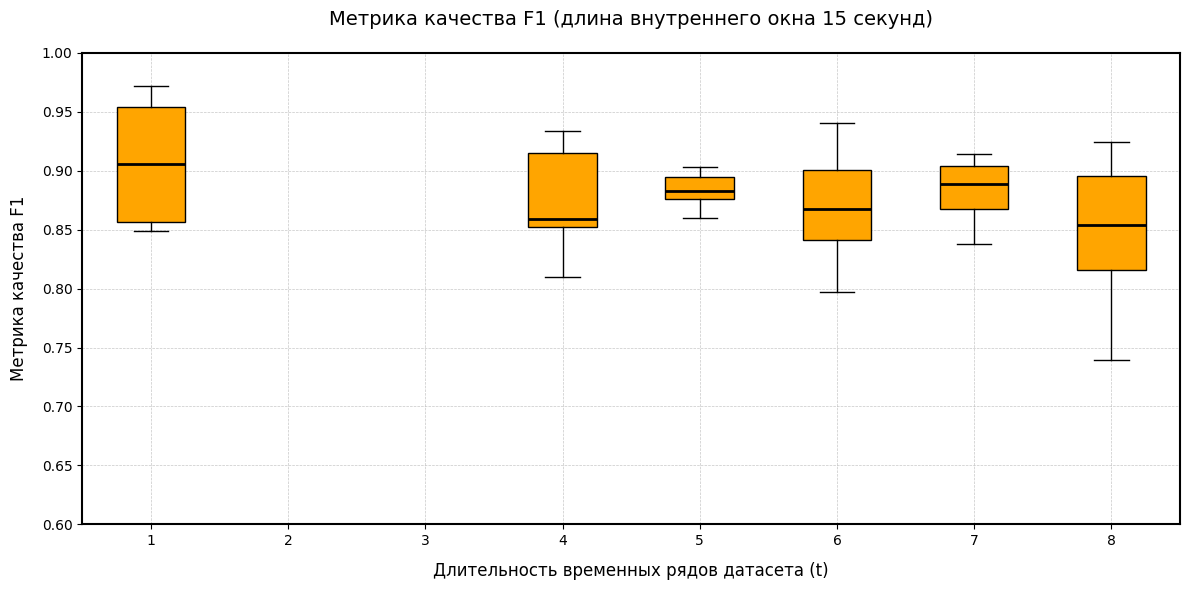

In [54]:
import numpy as np
import matplotlib.pyplot as plt



# Извлеченные значения F1-score для каждого timestep
f1_scores = {
    1: [0.971677559912854, 0.8508771929824561, 0.8925233644859814, 0.868421052631579,  0.8519362186788155, 0.9396551724137931, 0.8486238532110092, 0.9196428571428571, 0.9608695652173913, 0.9593147751605996],
    2: [],
    3: [],
    4: [0.8623024830699775, 0.9307359307359307, 0.851063829787234, 0.7433155080213903, 0.8552036199095022, 0.8095238095238095, 0.9230769230769231, 0.8564814814814815, 0.9336188436830836, 0.8913525498891353],
    5: [0.8785871964679912, 0.8847058823529412, 0.8838268792710706, 0.8755555555555555, 0.8597701149425288, 0.8822170900692841, 0.9383259911894273, 0.8663594470046083, 0.8984198645598194, 0.9028077753779697],
    6: [0.9224137931034483, 0.9406593406593406, 0.8367816091954023, 0.8597701149425288, 0.8765957446808511, 0.8744588744588745, 0.8558758314855875, 0.7970660146699267, 0.9082774049217002, 0.8],
    7: [0.9107142857142857, 0.9139072847682119, 0.8981481481481481, 0.8380952380952381, 0.905829596412556, 0.8654708520179372, 0.8826086956521739, 0.8741418764302059, 0.8951965065502183, 0.8393285371702638],
    8: [0.8519362186788155, 0.7393617021276596, 0.9070294784580499, 0.8133971291866029, 0.9241071428571429, 0.8564705882352941, 0.26119402985074625, 0.8691588785046729, 0.8232662192393736, 0.9042316258351893]
}

# Цвета для боксов
color_divisible = '#4CAF50'  # Зеленый (делится нацело)
color_not_divisible = '#FFA500'  # Оранжевый (не делится)
window_size = 15

# Подготовка данных для boxplot
timesteps = sorted(f1_scores.keys())
data = [f1_scores[ts] for ts in timesteps]

# Параметры стиля
boxprops = dict(linestyle='-', linewidth=1, color='black', facecolor='orange')
medianprops = dict(linestyle='-', linewidth=2, color='black')
whiskerprops = dict(linestyle='-', linewidth=1, color='black')
capprops = dict(linestyle='-', linewidth=1, color='black')
flierprops = dict(marker='o', markersize=8, markerfacecolor='grey')

# Создание boxplot
plt.figure(figsize=(12, 6))
box = plt.boxplot(data,
                 tick_labels=timesteps,
                 boxprops=boxprops,
                 medianprops=medianprops,
                 whiskerprops=whiskerprops,
                 capprops=capprops,
                 flierprops=flierprops,
                 patch_artist=True,
                  showfliers=False)  # Исправлено на tick_labels


plt.title('Метрика качества F1 (длина внутреннего окна 15 секунд)', fontsize=14, pad=20)
plt.xlabel('Длительность временных рядов датасета (t)', fontsize=12, labelpad=10)
plt.ylabel('Метрика качества F1', fontsize=12, labelpad=10)
plt.ylim(0.6, 1)
plt.grid(True, linestyle='--', alpha=0.7, linewidth=0.5)

plt.tight_layout()
# Увеличиваем толщину осей
for axis in ['top','bottom','left','right']:
    plt.gca().spines[axis].set_linewidth(1.5)

plt.show()

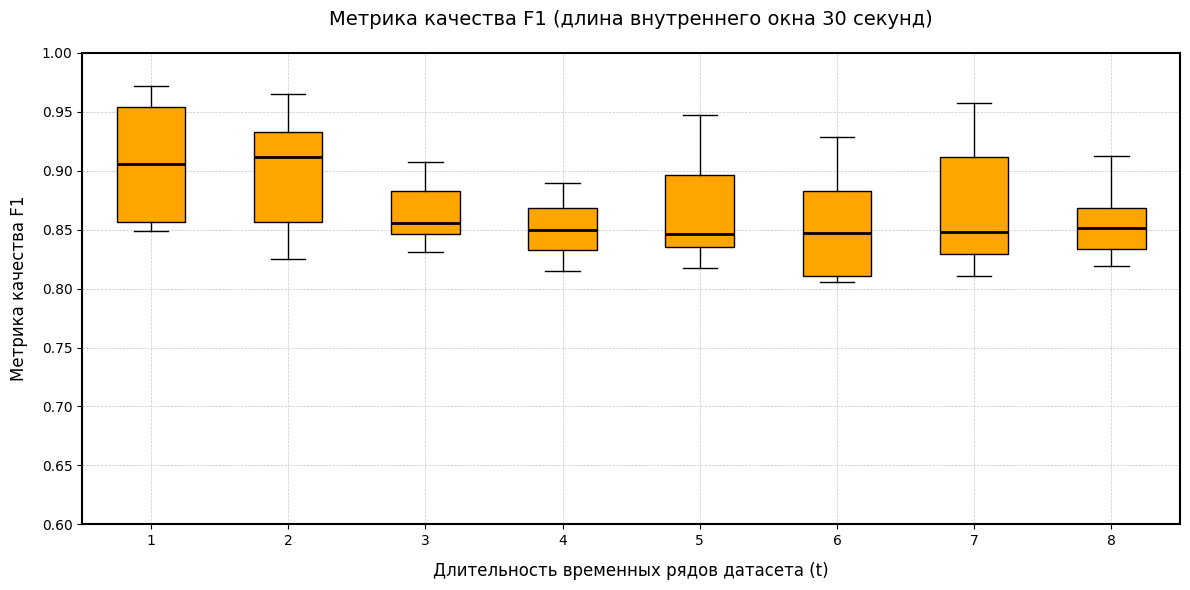

In [53]:
import numpy as np
import matplotlib.pyplot as plt



# Извлеченные значения F1-score для каждого timestep
f1_scores = {
    1: [0.971677559912854, 0.8508771929824561, 0.8925233644859814, 0.868421052631579,  0.8519362186788155, 0.9396551724137931, 0.8486238532110092, 0.9196428571428571, 0.9608695652173913, 0.9593147751605996],
    2: [0.9188034188034188, 0.9044289044289044, 0.9336283185840708, 0.8440366972477065, 0.8951965065502183, 0.825, 0.9550321199143469, 0.8344988344988346, 0.9301310043668122, 0.9650655021834061],
    3: [0.8473804100227791, 0.9393939393939394, 0.8308977035490606, 0.8898876404494382, 0.8608695652173913, 0.8610478359908884, 0.8463356973995272, 0.8509615384615384, 0.8423529411764706, 0.90744920993228],
    4: [0.8444444444444444, 0.8354430379746836, 0.9385964912280702, 0.6235294117647059, 0.8546637744034707, 0.8551724137931035, 0.8318965517241379, 0.8153153153153153, 0.8726415094339622, 0.8898876404494382],
    5: [0.8346153846153846, 0.8977777777777778, 0.6217008797653959, 0.8511627906976744, 0.9356223175965666, 0.8177339901477833, 0.9473684210526315, 0.8356807511737089, 0.8414096916299559, 0.8928571428571429],
    6: [0.8314606741573034, 0.8091954022988506, 0.813953488372093, 0.8619854721549637, 0.8054919908466819, 0.9288888888888889, 0.8665105386416861, 0.888402625820569, 0.8978723404255319, 0.6797752808988764],
    7: [0.9509594882729211, 0.8290398126463701, 0.9572649572649573, 0.8108108108108109, 0.9247311827956989, 0.8577981651376146, 0.8374164810690423, 0.6324786324786325, 0.8301886792452831, 0.8729792147806005],
    8: [0.89749430523918, 0.819047619047619, 0.9122807017543859, 0.8519362186788155, 0.8707482993197279, 0.8617511520737328, 0.85, 0.8300220750551877, 0.7786259541984732, 0.8452655889145496]
}

# Цвета для боксов
color_divisible = '#4CAF50'  # Зеленый (делится нацело)
color_not_divisible = '#FFA500'  # Оранжевый (не делится)
window_size = 30

# Подготовка данных для boxplot
timesteps = sorted(f1_scores.keys())
data = [f1_scores[ts] for ts in timesteps]

# Параметры стиля
boxprops = dict(linestyle='-', linewidth=1, color='black', facecolor='orange')
medianprops = dict(linestyle='-', linewidth=2, color='black')
whiskerprops = dict(linestyle='-', linewidth=1, color='black')
capprops = dict(linestyle='-', linewidth=1, color='black')
flierprops = dict(marker='o', markersize=8, markerfacecolor='grey')

# Создание boxplot
plt.figure(figsize=(12, 6))
box = plt.boxplot(data,
                 tick_labels=timesteps,
                 boxprops=boxprops,
                 medianprops=medianprops,
                 whiskerprops=whiskerprops,
                 capprops=capprops,
                 flierprops=flierprops,
                 patch_artist=True,
                  showfliers=False)  # Исправлено на tick_labels



plt.title('Метрика качества F1 (длина внутреннего окна 30 секунд)', fontsize=14, pad=20)
plt.xlabel('Длительность временных рядов датасета (t)', fontsize=12, labelpad=10)
plt.ylabel('Метрика качества F1', fontsize=12, labelpad=10)
plt.ylim(0.6, 1)
plt.grid(True, linestyle='--', alpha=0.7, linewidth=0.5)

plt.tight_layout()
# Увеличиваем толщину осей
for axis in ['top','bottom','left','right']:
    plt.gca().spines[axis].set_linewidth(1.5)

plt.show()

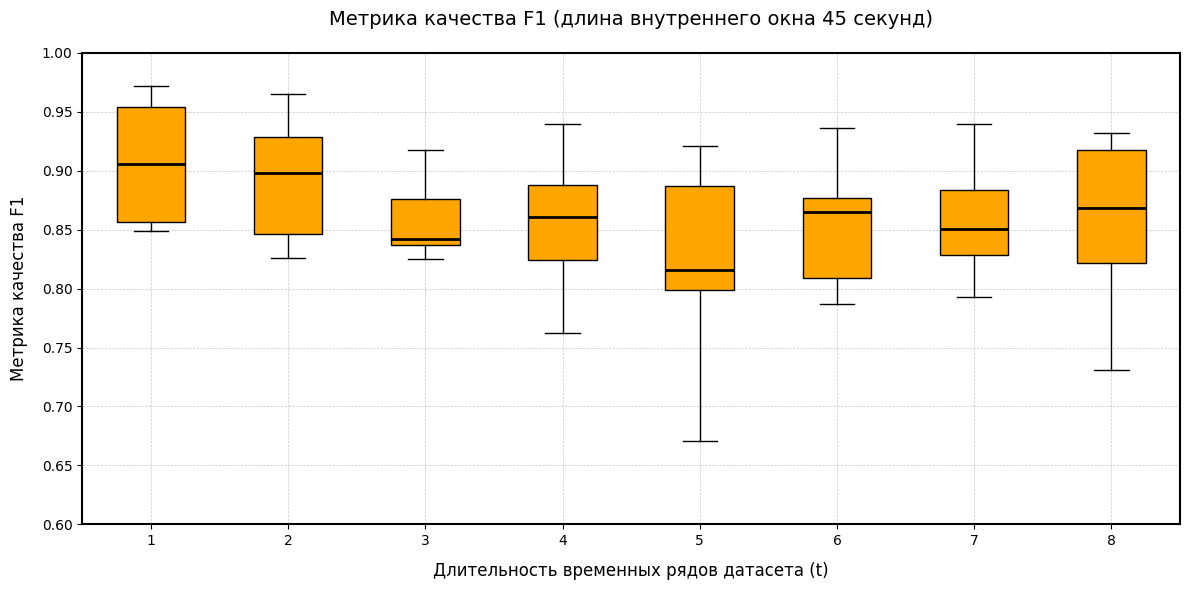

In [55]:
import numpy as np
import matplotlib.pyplot as plt

# Извлеченные значения F1-score для каждого timestep
f1_scores = {
    1: [0.971677559912854, 0.8508771929824561, 0.8925233644859814, 0.868421052631579,  0.8519362186788155, 0.9396551724137931, 0.8486238532110092, 0.9196428571428571, 0.9608695652173913, 0.9593147751605996],
    2: [0.9572649572649573, 0.8538283062645011, 0.84375, 0.8818181818181818, 0.9649122807017544, 0.9139072847682119, 0.8359550561797753, 0.9178082191780822, 0.9324618736383442, 0.82560706401766],
    3: [0.8381374722838137, 0.8421052631578947, 0.8824833702882483, 0.9173553719008265, 0.8413793103448276, 0.8571428571428571, 0.8364485981308412, 0.8251748251748252, 0.9166666666666666, 0.8251121076233184],
    4: [0.9396551724137931, 0.8237986270022883, 0.8486238532110092, 0.7981651376146789, 0.8741418764302059, 0.9333333333333333, 0.8248847926267281, 0.762402088772846, 0.8929384965831435, 0.8721461187214612],
    5: [0.7990867579908676, 0.9036402569593148, 0.9210526315789473, 0.7393617021276596, 0.8143459915611815, 0.8161434977578476, 0.8845315904139434, 0.8869179600886918, 0.6705035971223021],
    6: [0.8735632183908046, 0.9309576837416481, 0.8584269662921349, 0.8028846153846154, 0.8283261802575107, 0.936542669584245, 0.8028503562945368, 0.7868852459016393, 0.8707482993197279, 0.8773584905660378],
    7: [0.8893709327548807, 0.7969924812030075, 0.7930174563591023, 0.8847926267281107, 0.8514412416851441, 0.8275862068965517, 0.8320802005012531, 0.85, 0.8790697674418605, 0.9393939393939394],
    8: [0.8473118279569892, 0.7952380952380952, 0.9070796460176991, 0.8565488565488566, 0.926829268292683, 0.9213973799126638, 0.7306666666666667, 0.9321663019693655, 0.8808988764044944, 0.812807881773399]
}

# Подготовка данных для boxplot
timesteps = sorted(f1_scores.keys())
data = [f1_scores[ts] for ts in timesteps]

# Параметры стиля
boxprops = dict(linestyle='-', linewidth=1, color='black', facecolor='orange')
medianprops = dict(linestyle='-', linewidth=2, color='black')
whiskerprops = dict(linestyle='-', linewidth=1, color='black')
capprops = dict(linestyle='-', linewidth=1, color='black')
flierprops = dict(marker='o', markersize=8, markerfacecolor='grey')

# Создание boxplot
plt.figure(figsize=(12, 6))
box = plt.boxplot(data,
                 tick_labels=timesteps,
                 boxprops=boxprops,
                 medianprops=medianprops,
                 whiskerprops=whiskerprops,
                 capprops=capprops,
                 flierprops=flierprops,
                 patch_artist=True,
                  showfliers=False)  # Исправлено на tick_labels
plt.title('Метрика качества F1 (длина внутреннего окна 45 секунд)', fontsize=14, pad=20)
plt.xlabel('Длительность временных рядов датасета (t)', fontsize=12, labelpad=10)
plt.ylabel('Метрика качества F1', fontsize=12, labelpad=10)
plt.ylim(0.6, 1)
plt.grid(True, linestyle='--', alpha=0.7, linewidth=0.5)

plt.tight_layout()
# Увеличиваем толщину осей
for axis in ['top','bottom','left','right']:
    plt.gca().spines[axis].set_linewidth(1.5)

plt.show()

#Многоклассовая классификация

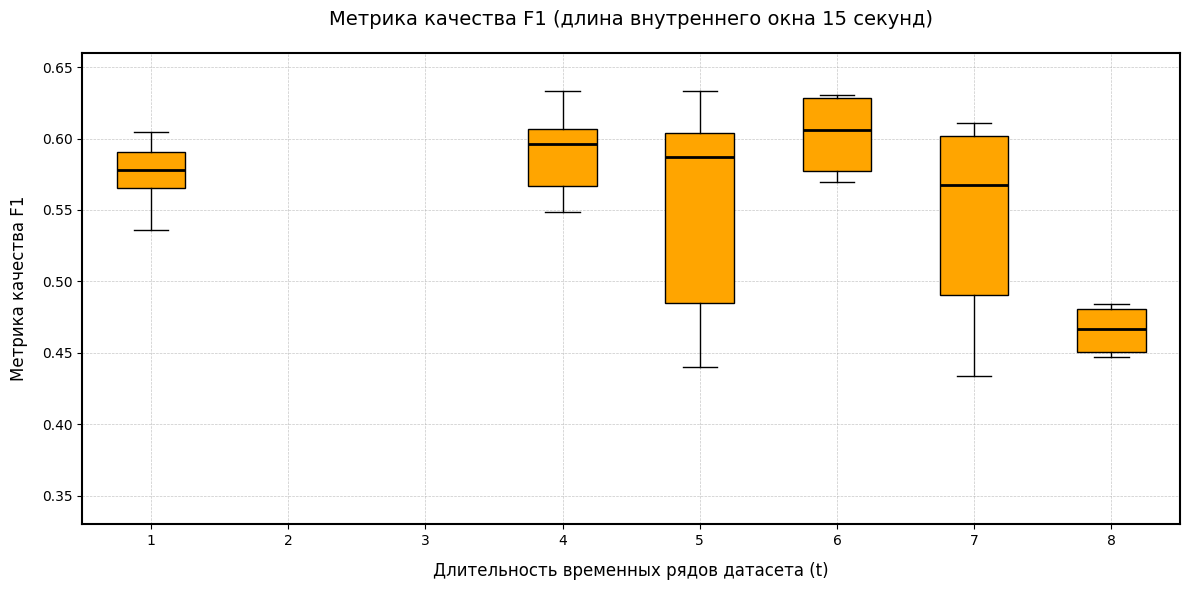

In [56]:
import numpy as np
import matplotlib.pyplot as plt



# Извлеченные значения F1-score для каждого timestep
f1_scores = {
    1: [0.5738743854209447, 0.5506296253980679, 0.5757179312871535, 0.6026051803215688, 0.5797761153679211, 0.5357170943864916, 0.6043878066413358, 0.5626259332055418, 0.5814116959265926, 0.5940429525580763],
    2: [],
    3: [],
    4: [0.6042886064317392, 0.6164671713148537, 0.5486836129902579, 0.5954255498226344, 0.5593522305023664, 0.4366416968438011, 0.5969468642286346, 0.6334687672690894, 0.607897929715052, 0.5903037959895091],
    5: [0.604203134594337, 0.6023113006911013, 0.5248357363257906, 0.5994827134980629, 0.4398157762399692, 0.5749840786234253, 0.6124445912436829, 0.6334631053572702, 0.45405721659193, 0.4718776705587251],
    6: [0.32930487104127926, 0.6119068747110659, 0.6259511298125867, 0.5698753366394802, 0.5990512479447703, 0.6300258233660425, 0.6292753225841135, 0.4864152987695561, 0.6000422774001258, 0.6308000301675477],
    7: [0.4339846345653912, 0.5647217889460768, 0.5966791915731628, 0.5341463799795038, 0.46944508168727134, 0.6108863996214782, 0.5695738187357633, 0.603452369902586, 0.6105438810071585, 0.4761072832759783],
    8: [0.610883262285714, 0.5447746821466515, 0.4720984255001655, 0.2931409617310846, 0.4838739620705561, 0.45991329046047896, 0.46739349582280776, 0.31859479252519435, 0.4471314927323511, 0.465514932582111]
}

# Цвета для боксов
color_divisible = '#4CAF50'  # Зеленый (делится нацело)
color_not_divisible = '#FFA500'  # Оранжевый (не делится)
window_size = 15

# Подготовка данных для boxplot
timesteps = sorted(f1_scores.keys())
data = [f1_scores[ts] for ts in timesteps]

# Параметры стиля
boxprops = dict(linestyle='-', linewidth=1, color='black', facecolor='orange')
medianprops = dict(linestyle='-', linewidth=2, color='black')
whiskerprops = dict(linestyle='-', linewidth=1, color='black')
capprops = dict(linestyle='-', linewidth=1, color='black')
flierprops = dict(marker='o', markersize=8, markerfacecolor='grey')

# Создание boxplot
plt.figure(figsize=(12, 6))
box = plt.boxplot(data,
                 tick_labels=timesteps,
                 boxprops=boxprops,
                 medianprops=medianprops,
                 whiskerprops=whiskerprops,
                 capprops=capprops,
                 flierprops=flierprops,
                 patch_artist=True,
                  showfliers=False)  # Исправлено на tick_labels


plt.title('Метрика качества F1 (длина внутреннего окна 15 секунд)', fontsize=14, pad=20)
plt.xlabel('Длительность временных рядов датасета (t)', fontsize=12, labelpad=10)
plt.ylabel('Метрика качества F1', fontsize=12, labelpad=10)
plt.ylim(0.33, 0.66)
plt.grid(True, linestyle='--', alpha=0.7, linewidth=0.5)

plt.tight_layout()
# Увеличиваем толщину осей
for axis in ['top','bottom','left','right']:
    plt.gca().spines[axis].set_linewidth(1.5)

plt.show()

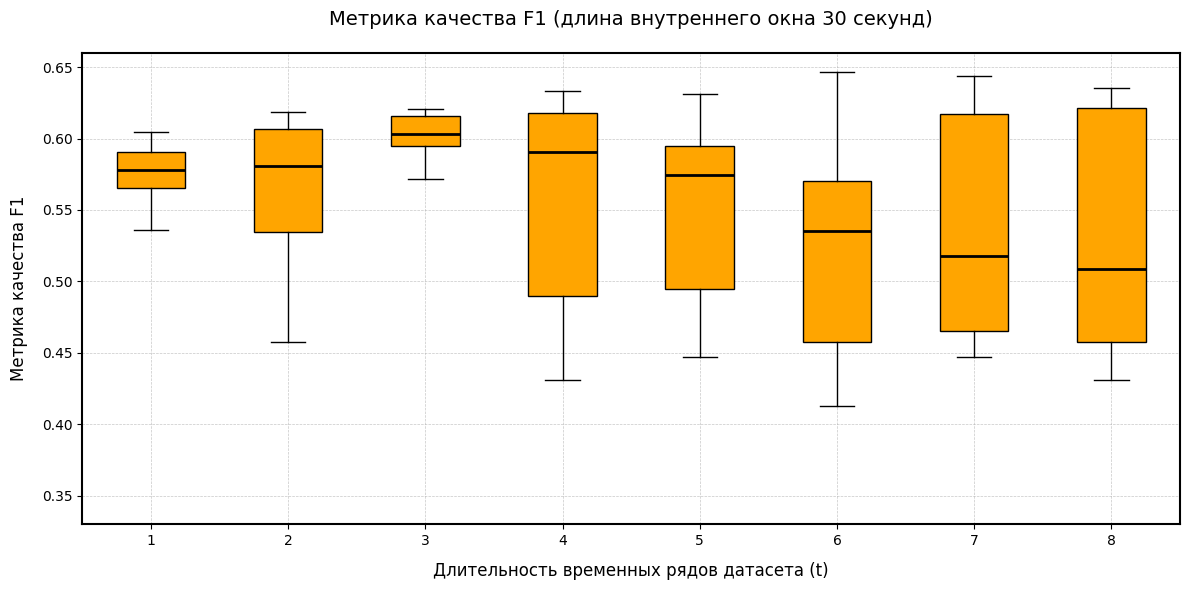

In [57]:
import numpy as np
import matplotlib.pyplot as plt



# Извлеченные значения F1-score для каждого timestep
f1_scores = {
    1: [0.5738743854209447, 0.5506296253980679, 0.5757179312871535, 0.6026051803215688, 0.5797761153679211, 0.5357170943864916, 0.6043878066413358, 0.5626259332055418, 0.5814116959265926, 0.5940429525580763],
    2: [0.4576043411016842, 0.6111063614014438, 0.6188237704343642, 0.4984449030666873, 0.5277680846878896, 0.5788833122368285, 0.5551915528287745, 0.6177694849675787, 0.5830919333547414, 0.5929981112854146],
    3: [0.5986450385692574, 0.6175402810675801, 0.5618374540837126, 0.5719069122698833, 0.6197414936201231, 0.6107245109315689, 0.5934106464524681, 0.620952803036615, 0.5987672991613773, 0.6073954004392201],
    4: [0.4311468048908089, 0.6333067771421256, 0.6305186767144175, 0.4514918048013762, 0.5921196426404706, 0.4631167620411999, 0.6202211903926259, 0.5704551891365025, 0.588417858036317, 0.6104415820796427],
    5: [0.5886488062012835, 0.6308985280245856, 0.5832424541623156, 0.4858204695592321, 0.46351751611790665, 0.5967024986632828, 0.44702865828864247, 0.6221411091640578, 0.5208984765021064, 0.5655921824622316],
    6: [0.5225856555565818, 0.4129169641550471, 0.5669271162435139, 0.6463016611031632, 0.450534004673325, 0.4459741386184543, 0.48009079141893785, 0.5474920729292335, 0.5716837746261387, 0.63273419392044],
    7: [0.4471449673767469, 0.4690963369912887, 0.6284572360640404, 0.5536682151605189, 0.584408830403719, 0.6439267994433008, 0.4642944625542217, 0.48162297677276233, 0.6300147484638483, 0.4504155094887523],
    8: [0.4307920951760892, 0.4704122692178411, 0.5187323329087596, 0.6355376008512087, 0.45303778263476263, 0.6219165253029907, 0.498940268453366, 0.6209458461223236, 0.44892255750384075, 0.6245607319890423]
}

# Цвета для боксов
color_divisible = '#4CAF50'  # Зеленый (делится нацело)
color_not_divisible = '#FFA500'  # Оранжевый (не делится)
window_size = 15

# Подготовка данных для boxplot
timesteps = sorted(f1_scores.keys())
data = [f1_scores[ts] for ts in timesteps]

# Параметры стиля
boxprops = dict(linestyle='-', linewidth=1, color='black', facecolor='orange')
medianprops = dict(linestyle='-', linewidth=2, color='black')
whiskerprops = dict(linestyle='-', linewidth=1, color='black')
capprops = dict(linestyle='-', linewidth=1, color='black')
flierprops = dict(marker='o', markersize=8, markerfacecolor='grey')

# Создание boxplot
plt.figure(figsize=(12, 6))
box = plt.boxplot(data,
                 tick_labels=timesteps,
                 boxprops=boxprops,
                 medianprops=medianprops,
                 whiskerprops=whiskerprops,
                 capprops=capprops,
                 flierprops=flierprops,
                 patch_artist=True,
                  showfliers=False)  # Исправлено на tick_labels


plt.title('Метрика качества F1 (длина внутреннего окна 30 секунд)', fontsize=14, pad=20)
plt.xlabel('Длительность временных рядов датасета (t)', fontsize=12, labelpad=10)
plt.ylabel('Метрика качества F1', fontsize=12, labelpad=10)
plt.ylim(0.33, 0.66)
plt.grid(True, linestyle='--', alpha=0.7, linewidth=0.5)

plt.tight_layout()
# Увеличиваем толщину осей
for axis in ['top','bottom','left','right']:
    plt.gca().spines[axis].set_linewidth(1.5)

plt.show()

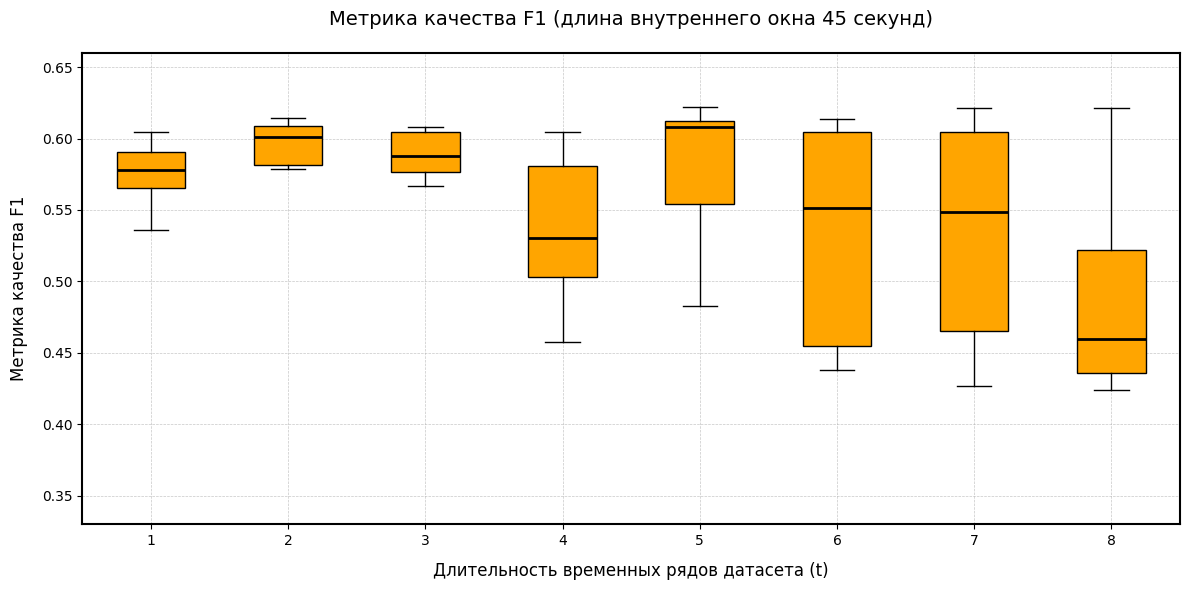

In [58]:
import numpy as np
import matplotlib.pyplot as plt



# Извлеченные значения F1-score для каждого timestep
f1_scores = {
    1: [0.5738743854209447, 0.5506296253980679, 0.5757179312871535, 0.6026051803215688, 0.5797761153679211, 0.5357170943864916, 0.6043878066413358, 0.5626259332055418, 0.5814116959265926, 0.5940429525580763],
    2: [0.6076239359808103, 0.6142354510531358, 0.6094591831851303, 0.5989120726595013, 0.6034411329595224, 0.5788549960100501, 0.5808330273329462, 0.4454552250898486, 0.61090301892183, 0.5828965899690984],
    3: [0.5846063275957571, 0.6060708748330271, 0.4480266825450483, 0.6080329328865298, 0.5801746356741969, 0.6048910717167297, 0.5665364533886592, 0.6042117777173279, 0.5754976028581179, 0.5911468078734329],
    4: [0.5436994979268526, 0.604602864428041, 0.5868394219588697, 0.4578841100254669, 0.4585373282219026, 0.5023092177881338, 0.5614807648266167, 0.5893806810363363, 0.5044837577043177, 0.5177383291619466],
    5: [0.48259749784168227, 0.5998885291834445, 0.6221675878346868, 0.5386602665639416, 0.621938634673113, 0.6060327873419745, 0.6106353296879445, 0.5381124006275176, 0.6128803201564413, 0.6108724627435476],
    6: [0.4442251892842317, 0.6139814091959221, 0.6133290494825356, 0.6074644907529286, 0.4379645200423763, 0.5486130147579666, 0.5959471462361482, 0.5544603525261118, 0.4599136248398372, 0.4526918380641775],
    7: [0.526752435771889, 0.47193579922807305, 0.6106697938926505, 0.4266741968918069, 0.4595703783653448, 0.6121297061816078, 0.46277039403191805, 0.6211048559713596, 0.5859596395008806, 0.5701671655361172],
    8: [0.445891160905311, 0.432540883999168, 0.26743563284921584, 0.6212493605730145, 0.46048563214704874, 0.5329749029471831, 0.6088319902773144, 0.4239184291924789, 0.4591232821492225, 0.4893286667076215]
}

# Цвета для боксов
color_divisible = '#4CAF50'  # Зеленый (делится нацело)
color_not_divisible = '#FFA500'  # Оранжевый (не делится)
window_size = 15

# Подготовка данных для boxplot
timesteps = sorted(f1_scores.keys())
data = [f1_scores[ts] for ts in timesteps]

# Параметры стиля
boxprops = dict(linestyle='-', linewidth=1, color='black', facecolor='orange')
medianprops = dict(linestyle='-', linewidth=2, color='black')
whiskerprops = dict(linestyle='-', linewidth=1, color='black')
capprops = dict(linestyle='-', linewidth=1, color='black')
flierprops = dict(marker='o', markersize=8, markerfacecolor='grey')

# Создание boxplot
plt.figure(figsize=(12, 6))
box = plt.boxplot(data,
                 tick_labels=timesteps,
                 boxprops=boxprops,
                 medianprops=medianprops,
                 whiskerprops=whiskerprops,
                 capprops=capprops,
                 flierprops=flierprops,
                 patch_artist=True,
                  showfliers=False)  # Исправлено на tick_labels


plt.title('Метрика качества F1 (длина внутреннего окна 45 секунд)', fontsize=14, pad=20)
plt.xlabel('Длительность временных рядов датасета (t)', fontsize=12, labelpad=10)
plt.ylabel('Метрика качества F1', fontsize=12, labelpad=10)
plt.ylim(0.33, 0.66)
plt.grid(True, linestyle='--', alpha=0.7, linewidth=0.5)

plt.tight_layout()
# Увеличиваем толщину осей
for axis in ['top','bottom','left','right']:
    plt.gca().spines[axis].set_linewidth(1.5)

plt.show()

#Время

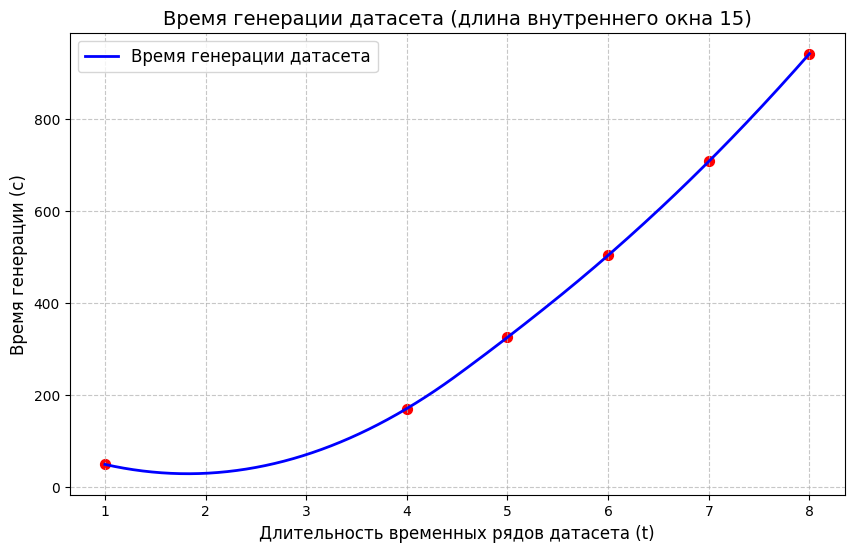

In [70]:
from scipy.interpolate import make_interp_spline

x = np.array([1, 4, 5, 6, 7, 8])  # Создаем массив x от 1 до 10
y = np.array([48.54, 170.2, 325.26, 503.82, 708.47, 943.01])  # Массив y из введенных чисел

x_smooth = np.linspace(x.min(), x.max(), 300)  # 300 точек для гладкости
spl = make_interp_spline(x, y, k=2)  # Кубический сплайн
y_smooth = spl(x_smooth)

# Настраиваем график
plt.figure(figsize=(10, 6))
plt.plot(x_smooth, y_smooth, 'b-', linewidth=2, label='Время генерации датасета')
plt.scatter(x, y, color='red', s=50)

# Добавляем подписи
plt.title('Время генерации датасета (длина внутреннего окна 15)', fontsize=14)
plt.xlabel('Длительность временных рядов датасета (t)', fontsize=12)
plt.ylabel('Время генерации (с)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Показываем график
plt.show()

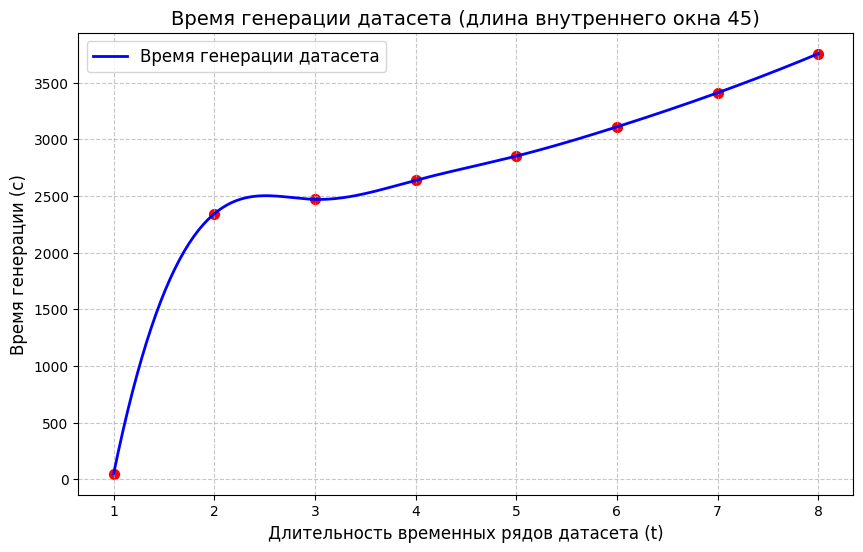

In [67]:
from scipy.interpolate import make_interp_spline

x = np.array([1, 2, 3, 4, 5, 6, 7, 8])  # Создаем массив x от 1 до 10
y = np.array([48.54, 2343.1, 2469.88, 2638.20, 2852.15, 3110.06, 3410.64, 3755.67])  # Массив y из введенных чисел

x_smooth = np.linspace(x.min(), x.max(), 300)  # 300 точек для гладкости
spl = make_interp_spline(x, y, k=3)  # Кубический сплайн
y_smooth = spl(x_smooth)

# Настраиваем график
plt.figure(figsize=(10, 6))
plt.plot(x_smooth, y_smooth, 'b-', linewidth=2, label='Время генерации датасета')
plt.scatter(x, y, color='red', s=50)

# Добавляем подписи
plt.title('Время генерации датасета (длина внутреннего окна 45)', fontsize=14)
plt.xlabel('Длительность временных рядов датасета (t)', fontsize=12)
plt.ylabel('Время генерации (с)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Показываем график
plt.show()

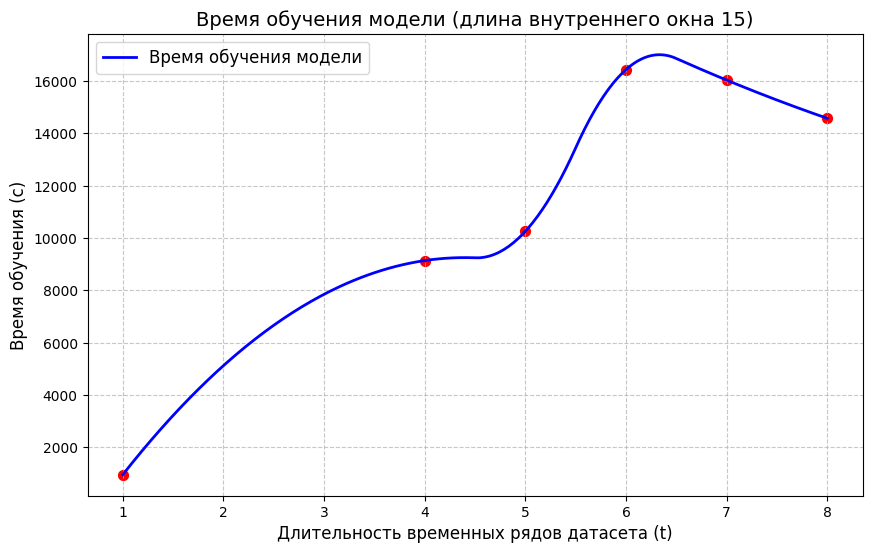

In [71]:
from scipy.interpolate import make_interp_spline

x = np.array([1, 4, 5, 6, 7, 8])  # Создаем массив x от 1 до 10
y = np.array([954.13, 9139.88, 10258.33, 16440.07, 16037.95, 14577.40])  # Массив y из введенных чисел

x_smooth = np.linspace(x.min(), x.max(), 300)  # 300 точек для гладкости
spl = make_interp_spline(x, y, k=2)  # Кубический сплайн
y_smooth = spl(x_smooth)

# Настраиваем график
plt.figure(figsize=(10, 6))
plt.plot(x_smooth, y_smooth, 'b-', linewidth=2, label='Время обучения модели')
plt.scatter(x, y, color='red', s=50)

# Добавляем подписи
plt.title('Время обучения модели (длина внутреннего окна 15)', fontsize=14)
plt.xlabel('Длительность временных рядов датасета (t)', fontsize=12)
plt.ylabel('Время обучения (с)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Показываем график
plt.show()

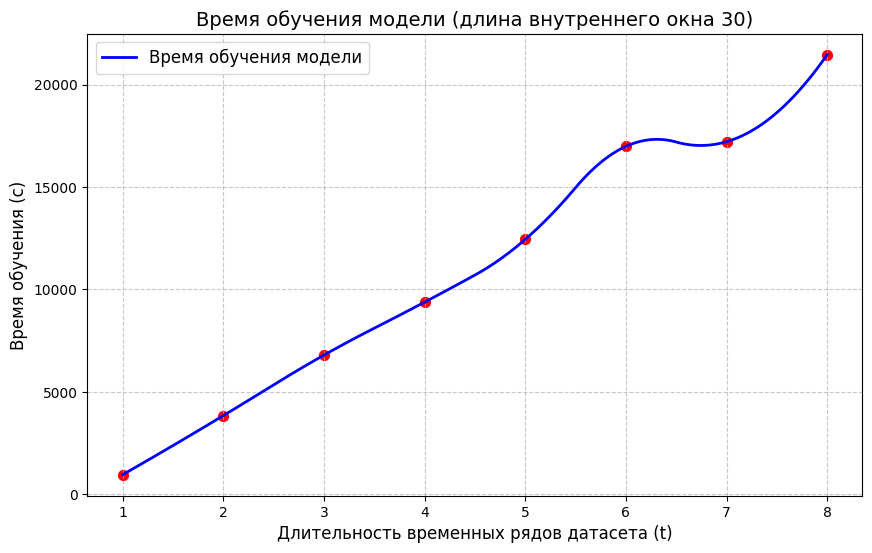

In [73]:
from scipy.interpolate import make_interp_spline

x = np.array([1, 2, 3, 4, 5, 6, 7, 8])  # Создаем массив x от 1 до 10
y = np.array([954.13, 3837.42, 6791.24, 9376.36, 12438.16, 16979.87, 17206.97, 21453.65])  # Массив y из введенных чисел

x_smooth = np.linspace(x.min(), x.max(), 300)  # 300 точек для гладкости
spl = make_interp_spline(x, y, k=2)  # Кубический сплайн
y_smooth = spl(x_smooth)

# Настраиваем график
plt.figure(figsize=(10, 6))
plt.plot(x_smooth, y_smooth, 'b-', linewidth=2, label='Время обучения модели')
plt.scatter(x, y, color='red', s=50)

# Добавляем подписи
plt.title('Время обучения модели (длина внутреннего окна 30)', fontsize=14)
plt.xlabel('Длительность временных рядов датасета (t)', fontsize=12)
plt.ylabel('Время обучения (с)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Показываем график
plt.show()

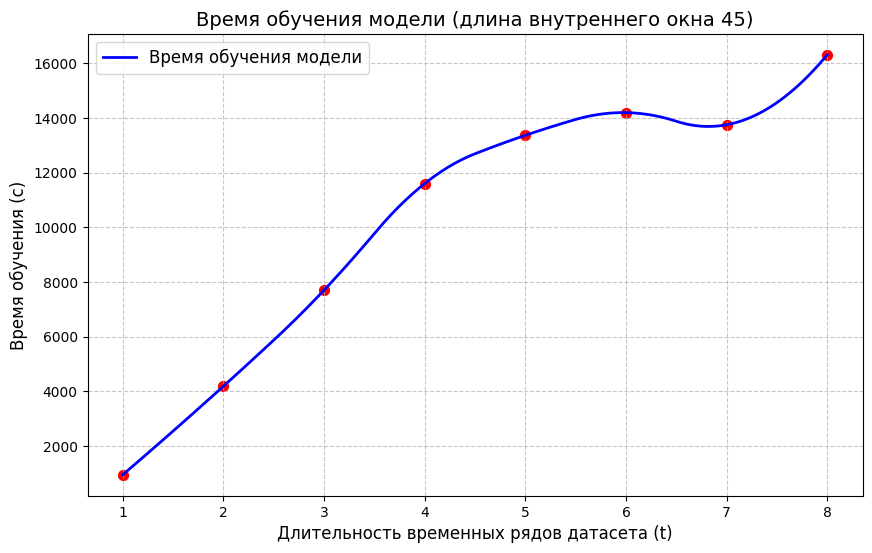

In [74]:
from scipy.interpolate import make_interp_spline

x = np.array([1, 2, 3, 4, 5, 6, 7, 8])  # Создаем массив x от 1 до 10
y = np.array([954.13, 4187.36, 7699.87, 11595.83, 13359.30, 14188.54, 13745.03, 16304.79])  # Массив y из введенных чисел

x_smooth = np.linspace(x.min(), x.max(), 300)  # 300 точек для гладкости
spl = make_interp_spline(x, y, k=2)  # Кубический сплайн
y_smooth = spl(x_smooth)

# Настраиваем график
plt.figure(figsize=(10, 6))
plt.plot(x_smooth, y_smooth, 'b-', linewidth=2, label='Время обучения модели')
plt.scatter(x, y, color='red', s=50)

# Добавляем подписи
plt.title('Время обучения модели (длина внутреннего окна 45)', fontsize=14)
plt.xlabel('Длительность временных рядов датасета (t)', fontsize=12)
plt.ylabel('Время обучения (с)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Показываем график
plt.show()

#Память

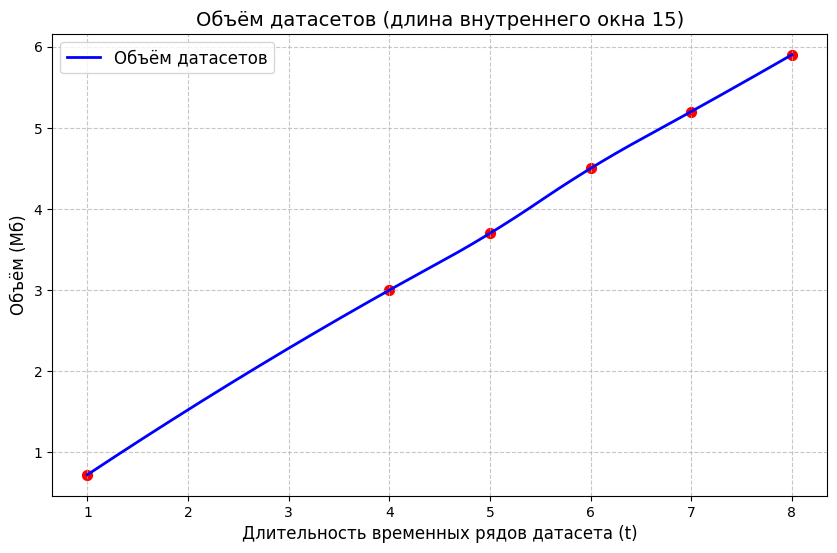

In [75]:
from scipy.interpolate import make_interp_spline

x = np.array([1, 4, 5, 6, 7, 8])  # Создаем массив x от 1 до 10
y = np.array([0.726, 3, 3.7, 4.5, 5.2, 5.9])  # Массив y из введенных чисел

x_smooth = np.linspace(x.min(), x.max(), 300)  # 300 точек для гладкости
spl = make_interp_spline(x, y, k=2)  # Кубический сплайн
y_smooth = spl(x_smooth)

# Настраиваем график
plt.figure(figsize=(10, 6))
plt.plot(x_smooth, y_smooth, 'b-', linewidth=2, label='Объём датасетов')
plt.scatter(x, y, color='red', s=50)

# Добавляем подписи
plt.title('Объём датасетов (длина внутреннего окна 15)', fontsize=14)
plt.xlabel('Длительность временных рядов датасета (t)', fontsize=12)
plt.ylabel('Объём (Мб)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Показываем график
plt.show()

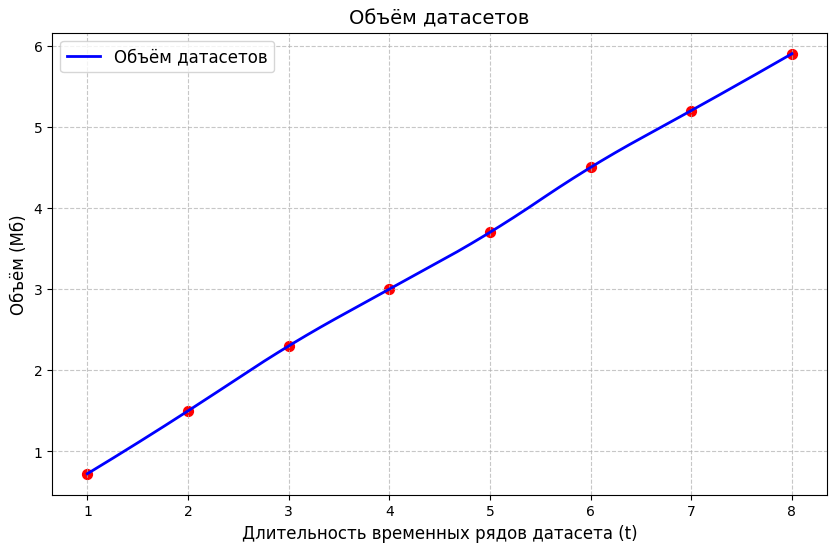

In [78]:
from scipy.interpolate import make_interp_spline

x = np.array([1, 2, 3, 4, 5, 6, 7, 8])  # Создаем массив x от 1 до 10
y = np.array([0.726, 1.5, 2.3, 3, 3.7, 4.5, 5.2, 5.9])  # Массив y из введенных чисел

x_smooth = np.linspace(x.min(), x.max(), 300)  # 300 точек для гладкости
spl = make_interp_spline(x, y, k=2)  # Кубический сплайн
y_smooth = spl(x_smooth)

# Настраиваем график
plt.figure(figsize=(10, 6))
plt.plot(x_smooth, y_smooth, 'b-', linewidth=2, label='Объём датасетов')
plt.scatter(x, y, color='red', s=50)

# Добавляем подписи
plt.title('Объём датасетов', fontsize=14)
plt.xlabel('Длительность временных рядов датасета (t)', fontsize=12)
plt.ylabel('Объём (Мб)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Показываем график
plt.show()

In [ ]:
from scipy.interpolate import make_interp_spline

x = np.array([1, 2, 3, 4, 5, 6, 7, 8])  # Создаем массив x от 1 до 10
y = np.array([0.726, 1.5, 2.3, 3, 3.7, 4.5, 5.2, 5.9])  # Массив y из введенных чисел

x_smooth = np.linspace(x.min(), x.max(), 300)  # 300 точек для гладкости
spl = make_interp_spline(x, y, k=2)  # Кубический сплайн
y_smooth = spl(x_smooth)

# Настраиваем график
plt.figure(figsize=(10, 6))
plt.plot(x_smooth, y_smooth, 'b-', linewidth=2, label='Объём датасетов')
plt.scatter(x, y, color='red', s=50)

# Добавляем подписи
plt.title('Объём датасетов (длина внутреннего окна 30)', fontsize=14)
plt.xlabel('Длительность временных рядов датасета (t)', fontsize=12)
plt.ylabel('Объём (Мб)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Показываем график
plt.show()